In [4]:
import os
from pathlib import Path

from gnn_tracking_legacy.postprocessing.dbscanscanner import dbscan_scan

from gnn_tracking_legacy.models.graph_construction import GraphConstructionFCNN
from tcn_trainer import TCNTrainer

from gnn_tracking_legacy.metrics.losses import GraphConstructionHingeEmbeddingLoss
from gnn_tracking_legacy.utils.loading import get_loaders, TrackingDataset

In [2]:
graph_dir = Path("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1")
assert graph_dir.is_dir()

In [5]:
dirs = []
for file in os.listdir(graph_dir):
    d = os.path.join(graph_dir, file)
    if os.path.isdir(d):
        dirs.append(d)

In [6]:
dirs

['/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_6',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_2',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_4',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_5',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_1',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_7',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_3',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_9',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0']

In [10]:
datasets = {
    "train": TrackingDataset(dirs, stop=810),
    "val": TrackingDataset(dirs, start=810, stop=900),
}
loaders = get_loaders(datasets, batch_size=4)

[10:16:40] INFO: DataLoader will load 810 graphs (out of 900 available).
[10:16:40] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[10:16:40] INFO: DataLoader will load 90 graphs (out of 900 available).
[10:16:40] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_9/data21009_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_9/data21986_s0.pt
[10:16:40] DEBUG: Parameters for data loader 'train': {'batch_size': 4, 'num_workers': 1, 'sampler': <torch.utils.data.sampler.RandomSampler object at 0x1545690650c0>, 'pin_memory': True, 'shuffle': None}
[10:16:40] DEBUG: Parameters for data loader 'val': {'batch_size': 1, 'num_workers': 1, 'sampler': None, 'pin_memory': True, 'shuf

In [8]:
def list_of_dicts_to_dict_of_lists(list_of_dicts):
    dict_of_lists = {}
    for dictionary in list_of_dicts:
        for key, value in dictionary.items():
            dict_of_lists.setdefault(key, []).append(value)
    return dict_of_lists

In [15]:
def train_model(weight_attractive, weight_repulsive, loaders, num_epochs=50):

    loss_functions = {
        "embedding_loss": (GraphConstructionHingeEmbeddingLoss(), {"attractive": weight_attractive,
                                                                   "repulsive": weight_repulsive})
    }

    model = GraphConstructionFCNN(
        in_dim = 14,
        hidden_dim = 64,
        out_dim = 10,
        depth = 5,
        beta = 0.4
    )

    trainer = TCNTrainer(
        model=model,
        loaders=loaders,
        loss_functions=loss_functions,
        lr=7e-4,
    )

    loss_history = trainer.train(epochs=num_epochs)
    return list_of_dicts_to_dict_of_lists(loss_history)

In [16]:
loss_history = train_model(weight_attractive=1.0,
                             weight_repulsive=0.2,
                             loaders=loaders,
                             num_epochs=100)

[10:21:41 TCNTrainer] INFO: Using device cuda
/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:21:41 TCNTrainer] DEBUG: Epoch 1 (    0/203): Total=   0.02519, embedding_loss_attractive=   0.02493, embedding_loss_repulsive=   0.00026 (weighted)
[10:21:41 TCNTrainer] DEBUG: Epoch 1 (   10/203): Total=   0.01018, embedding_loss_attractive=   0.00980, embedding_loss_repulsive=   0.00038 (weighted)
[10:21:41 TCNTrainer] DEBUG: Epoch 1 (   20/203): Total=   0.00610, embedding_loss_attractive=   0.00551, embedding_loss_repulsive=   0.00059 (weighted)
[10:21:41 TCNTrainer] DEBUG: Epoch 1 (   30/203): Total= 

[10:21:47 TCNTrainer] DEBUG: Epoch 2 (  110/203): Total=   0.00211, embedding_loss_attractive=   0.00147, embedding_loss_repulsive=   0.00063 (weighted)
[10:21:47 TCNTrainer] DEBUG: Epoch 2 (  120/203): Total=   0.00207, embedding_loss_attractive=   0.00151, embedding_loss_repulsive=   0.00055 (weighted)
[10:21:47 TCNTrainer] DEBUG: Epoch 2 (  130/203): Total=   0.00211, embedding_loss_attractive=   0.00154, embedding_loss_repulsive=   0.00058 (weighted)
[10:21:47 TCNTrainer] DEBUG: Epoch 2 (  140/203): Total=   0.00215, embedding_loss_attractive=   0.00158, embedding_loss_repulsive=   0.00057 (weighted)
[10:21:47 TCNTrainer] DEBUG: Epoch 2 (  150/203): Total=   0.00207, embedding_loss_attractive=   0.00157, embedding_loss_repulsive=   0.00050 (weighted)
[10:21:48 TCNTrainer] DEBUG: Epoch 2 (  160/203): Total=   0.00208, embedding_loss_attractive=   0.00154, embedding_loss_repulsive=   0.00055 (weighted)
[10:21:48 TCNTrainer] DEBUG: Epoch 2 (  170/203): Total=   0.00209, embedding_loss

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:21:53 TCNTrainer] DEBUG: Epoch 4 (    0/203): Total=   0.00189, embedding_loss_attractive=   0.00138, embedding_loss_repulsive=   0.00050 (weighted)
[10:21:54 TCNTrainer] DEBUG: Epoch 4 (   10/203): Total=   0.00199, embedding_loss_attractive=   0.00139, embedding_loss_repulsive=   0.00060 (weighted)
[10:21:54 TCNTrainer] DEBUG: Epoch 4 (   20/203): Total=   0.00197, embedding_loss_attractive=   0.00140, embedding_loss_repulsive=   0.00056 (weighted)
[10:21:54 TCNTrainer] DEBUG: Epoch 4 (   30/203): Total=   0.00198, embedding_loss_attractive=   0.0014

[10:21:59 TCNTrainer] DEBUG: Epoch 5 (  110/203): Total=   0.00178, embedding_loss_attractive=   0.00127, embedding_loss_repulsive=   0.00051 (weighted)
[10:21:59 TCNTrainer] DEBUG: Epoch 5 (  120/203): Total=   0.00175, embedding_loss_attractive=   0.00127, embedding_loss_repulsive=   0.00048 (weighted)
[10:22:00 TCNTrainer] DEBUG: Epoch 5 (  130/203): Total=   0.00171, embedding_loss_attractive=   0.00119, embedding_loss_repulsive=   0.00053 (weighted)
[10:22:00 TCNTrainer] DEBUG: Epoch 5 (  140/203): Total=   0.00169, embedding_loss_attractive=   0.00124, embedding_loss_repulsive=   0.00045 (weighted)
[10:22:00 TCNTrainer] DEBUG: Epoch 5 (  150/203): Total=   0.00179, embedding_loss_attractive=   0.00137, embedding_loss_repulsive=   0.00042 (weighted)
[10:22:00 TCNTrainer] DEBUG: Epoch 5 (  160/203): Total=   0.00179, embedding_loss_attractive=   0.00117, embedding_loss_repulsive=   0.00062 (weighted)
[10:22:00 TCNTrainer] DEBUG: Epoch 5 (  170/203): Total=   0.00178, embedding_loss

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:22:06 TCNTrainer] DEBUG: Epoch 7 (    0/203): Total=   0.00166, embedding_loss_attractive=   0.00119, embedding_loss_repulsive=   0.00048 (weighted)
[10:22:06 TCNTrainer] DEBUG: Epoch 7 (   10/203): Total=   0.00157, embedding_loss_attractive=   0.00116, embedding_loss_repulsive=   0.00040 (weighted)
[10:22:06 TCNTrainer] DEBUG: Epoch 7 (   20/203): Total=   0.00161, embedding_loss_attractive=   0.00111, embedding_loss_repulsive=   0.00050 (weighted)
[10:22:06 TCNTrainer] DEBUG: Epoch 7 (   30/203): Total=   0.00164, embedding_loss_attractive=   0.0012

[10:22:12 TCNTrainer] DEBUG: Epoch 8 (  110/203): Total=   0.00154, embedding_loss_attractive=   0.00109, embedding_loss_repulsive=   0.00045 (weighted)
[10:22:12 TCNTrainer] DEBUG: Epoch 8 (  120/203): Total=   0.00159, embedding_loss_attractive=   0.00110, embedding_loss_repulsive=   0.00048 (weighted)
[10:22:12 TCNTrainer] DEBUG: Epoch 8 (  130/203): Total=   0.00173, embedding_loss_attractive=   0.00119, embedding_loss_repulsive=   0.00054 (weighted)
[10:22:12 TCNTrainer] DEBUG: Epoch 8 (  140/203): Total=   0.00160, embedding_loss_attractive=   0.00114, embedding_loss_repulsive=   0.00046 (weighted)
[10:22:12 TCNTrainer] DEBUG: Epoch 8 (  150/203): Total=   0.00153, embedding_loss_attractive=   0.00117, embedding_loss_repulsive=   0.00037 (weighted)
[10:22:12 TCNTrainer] DEBUG: Epoch 8 (  160/203): Total=   0.00158, embedding_loss_attractive=   0.00118, embedding_loss_repulsive=   0.00040 (weighted)
[10:22:13 TCNTrainer] DEBUG: Epoch 8 (  170/203): Total=   0.00153, embedding_loss

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:22:18 TCNTrainer] DEBUG: Epoch 10 (    0/203): Total=   0.00154, embedding_loss_attractive=   0.00111, embedding_loss_repulsive=   0.00042 (weighted)
[10:22:18 TCNTrainer] DEBUG: Epoch 10 (   10/203): Total=   0.00144, embedding_loss_attractive=   0.00110, embedding_loss_repulsive=   0.00035 (weighted)
[10:22:18 TCNTrainer] DEBUG: Epoch 10 (   20/203): Total=   0.00170, embedding_loss_attractive=   0.00122, embedding_loss_repulsive=   0.00048 (weighted)
[10:22:19 TCNTrainer] DEBUG: Epoch 10 (   30/203): Total=   0.00166, embedding_loss_attractive=   0.

[10:22:24 TCNTrainer] DEBUG: Epoch 11 (  110/203): Total=   0.00156, embedding_loss_attractive=   0.00113, embedding_loss_repulsive=   0.00043 (weighted)
[10:22:24 TCNTrainer] DEBUG: Epoch 11 (  120/203): Total=   0.00145, embedding_loss_attractive=   0.00105, embedding_loss_repulsive=   0.00039 (weighted)
[10:22:24 TCNTrainer] DEBUG: Epoch 11 (  130/203): Total=   0.00151, embedding_loss_attractive=   0.00107, embedding_loss_repulsive=   0.00044 (weighted)
[10:22:24 TCNTrainer] DEBUG: Epoch 11 (  140/203): Total=   0.00143, embedding_loss_attractive=   0.00107, embedding_loss_repulsive=   0.00036 (weighted)
[10:22:25 TCNTrainer] DEBUG: Epoch 11 (  150/203): Total=   0.00149, embedding_loss_attractive=   0.00108, embedding_loss_repulsive=   0.00041 (weighted)
[10:22:25 TCNTrainer] DEBUG: Epoch 11 (  160/203): Total=   0.00142, embedding_loss_attractive=   0.00103, embedding_loss_repulsive=   0.00039 (weighted)
[10:22:25 TCNTrainer] DEBUG: Epoch 11 (  170/203): Total=   0.00143, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:22:31 TCNTrainer] DEBUG: Epoch 13 (    0/203): Total=   0.00147, embedding_loss_attractive=   0.00101, embedding_loss_repulsive=   0.00047 (weighted)
[10:22:31 TCNTrainer] DEBUG: Epoch 13 (   10/203): Total=   0.00138, embedding_loss_attractive=   0.00099, embedding_loss_repulsive=   0.00039 (weighted)
[10:22:31 TCNTrainer] DEBUG: Epoch 13 (   20/203): Total=   0.00147, embedding_loss_attractive=   0.00106, embedding_loss_repulsive=   0.00042 (weighted)
[10:22:31 TCNTrainer] DEBUG: Epoch 13 (   30/203): Total=   0.00142, embedding_loss_attractive=   0.

[10:22:36 TCNTrainer] DEBUG: Epoch 14 (  110/203): Total=   0.00148, embedding_loss_attractive=   0.00108, embedding_loss_repulsive=   0.00040 (weighted)
[10:22:36 TCNTrainer] DEBUG: Epoch 14 (  120/203): Total=   0.00134, embedding_loss_attractive=   0.00098, embedding_loss_repulsive=   0.00036 (weighted)
[10:22:37 TCNTrainer] DEBUG: Epoch 14 (  130/203): Total=   0.00144, embedding_loss_attractive=   0.00106, embedding_loss_repulsive=   0.00038 (weighted)
[10:22:37 TCNTrainer] DEBUG: Epoch 14 (  140/203): Total=   0.00144, embedding_loss_attractive=   0.00099, embedding_loss_repulsive=   0.00044 (weighted)
[10:22:37 TCNTrainer] DEBUG: Epoch 14 (  150/203): Total=   0.00143, embedding_loss_attractive=   0.00102, embedding_loss_repulsive=   0.00041 (weighted)
[10:22:37 TCNTrainer] DEBUG: Epoch 14 (  160/203): Total=   0.00143, embedding_loss_attractive=   0.00098, embedding_loss_repulsive=   0.00045 (weighted)
[10:22:37 TCNTrainer] DEBUG: Epoch 14 (  170/203): Total=   0.00145, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:22:43 TCNTrainer] DEBUG: Epoch 16 (    0/203): Total=   0.00139, embedding_loss_attractive=   0.00099, embedding_loss_repulsive=   0.00040 (weighted)
[10:22:43 TCNTrainer] DEBUG: Epoch 16 (   10/203): Total=   0.00141, embedding_loss_attractive=   0.00098, embedding_loss_repulsive=   0.00043 (weighted)
[10:22:43 TCNTrainer] DEBUG: Epoch 16 (   20/203): Total=   0.00142, embedding_loss_attractive=   0.00098, embedding_loss_repulsive=   0.00044 (weighted)
[10:22:43 TCNTrainer] DEBUG: Epoch 16 (   30/203): Total=   0.00137, embedding_loss_attractive=   0.

[10:22:49 TCNTrainer] DEBUG: Epoch 17 (  110/203): Total=   0.00134, embedding_loss_attractive=   0.00097, embedding_loss_repulsive=   0.00038 (weighted)
[10:22:49 TCNTrainer] DEBUG: Epoch 17 (  120/203): Total=   0.00134, embedding_loss_attractive=   0.00097, embedding_loss_repulsive=   0.00037 (weighted)
[10:22:49 TCNTrainer] DEBUG: Epoch 17 (  130/203): Total=   0.00138, embedding_loss_attractive=   0.00098, embedding_loss_repulsive=   0.00040 (weighted)
[10:22:49 TCNTrainer] DEBUG: Epoch 17 (  140/203): Total=   0.00138, embedding_loss_attractive=   0.00107, embedding_loss_repulsive=   0.00031 (weighted)
[10:22:49 TCNTrainer] DEBUG: Epoch 17 (  150/203): Total=   0.00142, embedding_loss_attractive=   0.00104, embedding_loss_repulsive=   0.00038 (weighted)
[10:22:49 TCNTrainer] DEBUG: Epoch 17 (  160/203): Total=   0.00140, embedding_loss_attractive=   0.00100, embedding_loss_repulsive=   0.00040 (weighted)
[10:22:50 TCNTrainer] DEBUG: Epoch 17 (  170/203): Total=   0.00132, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:22:55 TCNTrainer] DEBUG: Epoch 19 (    0/203): Total=   0.00149, embedding_loss_attractive=   0.00105, embedding_loss_repulsive=   0.00044 (weighted)
[10:22:55 TCNTrainer] DEBUG: Epoch 19 (   10/203): Total=   0.00152, embedding_loss_attractive=   0.00112, embedding_loss_repulsive=   0.00041 (weighted)
[10:22:55 TCNTrainer] DEBUG: Epoch 19 (   20/203): Total=   0.00141, embedding_loss_attractive=   0.00106, embedding_loss_repulsive=   0.00035 (weighted)
[10:22:56 TCNTrainer] DEBUG: Epoch 19 (   30/203): Total=   0.00136, embedding_loss_attractive=   0.

[10:23:01 TCNTrainer] DEBUG: Epoch 20 (  110/203): Total=   0.00135, embedding_loss_attractive=   0.00097, embedding_loss_repulsive=   0.00038 (weighted)
[10:23:01 TCNTrainer] DEBUG: Epoch 20 (  120/203): Total=   0.00130, embedding_loss_attractive=   0.00095, embedding_loss_repulsive=   0.00035 (weighted)
[10:23:01 TCNTrainer] DEBUG: Epoch 20 (  130/203): Total=   0.00131, embedding_loss_attractive=   0.00096, embedding_loss_repulsive=   0.00036 (weighted)
[10:23:01 TCNTrainer] DEBUG: Epoch 20 (  140/203): Total=   0.00143, embedding_loss_attractive=   0.00101, embedding_loss_repulsive=   0.00041 (weighted)
[10:23:02 TCNTrainer] DEBUG: Epoch 20 (  150/203): Total=   0.00135, embedding_loss_attractive=   0.00098, embedding_loss_repulsive=   0.00037 (weighted)
[10:23:02 TCNTrainer] DEBUG: Epoch 20 (  160/203): Total=   0.00138, embedding_loss_attractive=   0.00100, embedding_loss_repulsive=   0.00038 (weighted)
[10:23:02 TCNTrainer] DEBUG: Epoch 20 (  170/203): Total=   0.00133, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:23:07 TCNTrainer] DEBUG: Epoch 22 (    0/203): Total=   0.00137, embedding_loss_attractive=   0.00100, embedding_loss_repulsive=   0.00037 (weighted)
[10:23:08 TCNTrainer] DEBUG: Epoch 22 (   10/203): Total=   0.00134, embedding_loss_attractive=   0.00102, embedding_loss_repulsive=   0.00032 (weighted)
[10:23:08 TCNTrainer] DEBUG: Epoch 22 (   20/203): Total=   0.00138, embedding_loss_attractive=   0.00098, embedding_loss_repulsive=   0.00040 (weighted)
[10:23:08 TCNTrainer] DEBUG: Epoch 22 (   30/203): Total=   0.00133, embedding_loss_attractive=   0.

[10:23:13 TCNTrainer] DEBUG: Epoch 23 (  110/203): Total=   0.00133, embedding_loss_attractive=   0.00096, embedding_loss_repulsive=   0.00037 (weighted)
[10:23:13 TCNTrainer] DEBUG: Epoch 23 (  120/203): Total=   0.00129, embedding_loss_attractive=   0.00095, embedding_loss_repulsive=   0.00034 (weighted)
[10:23:14 TCNTrainer] DEBUG: Epoch 23 (  130/203): Total=   0.00136, embedding_loss_attractive=   0.00092, embedding_loss_repulsive=   0.00044 (weighted)
[10:23:14 TCNTrainer] DEBUG: Epoch 23 (  140/203): Total=   0.00131, embedding_loss_attractive=   0.00094, embedding_loss_repulsive=   0.00037 (weighted)
[10:23:14 TCNTrainer] DEBUG: Epoch 23 (  150/203): Total=   0.00133, embedding_loss_attractive=   0.00089, embedding_loss_repulsive=   0.00044 (weighted)
[10:23:14 TCNTrainer] DEBUG: Epoch 23 (  160/203): Total=   0.00133, embedding_loss_attractive=   0.00094, embedding_loss_repulsive=   0.00039 (weighted)
[10:23:14 TCNTrainer] DEBUG: Epoch 23 (  170/203): Total=   0.00131, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:23:20 TCNTrainer] DEBUG: Epoch 25 (    0/203): Total=   0.00136, embedding_loss_attractive=   0.00095, embedding_loss_repulsive=   0.00040 (weighted)
[10:23:20 TCNTrainer] DEBUG: Epoch 25 (   10/203): Total=   0.00131, embedding_loss_attractive=   0.00093, embedding_loss_repulsive=   0.00038 (weighted)
[10:23:20 TCNTrainer] DEBUG: Epoch 25 (   20/203): Total=   0.00130, embedding_loss_attractive=   0.00093, embedding_loss_repulsive=   0.00037 (weighted)
[10:23:20 TCNTrainer] DEBUG: Epoch 25 (   30/203): Total=   0.00127, embedding_loss_attractive=   0.

[10:23:26 TCNTrainer] DEBUG: Epoch 26 (  110/203): Total=   0.00130, embedding_loss_attractive=   0.00097, embedding_loss_repulsive=   0.00033 (weighted)
[10:23:26 TCNTrainer] DEBUG: Epoch 26 (  120/203): Total=   0.00133, embedding_loss_attractive=   0.00094, embedding_loss_repulsive=   0.00039 (weighted)
[10:23:26 TCNTrainer] DEBUG: Epoch 26 (  130/203): Total=   0.00130, embedding_loss_attractive=   0.00089, embedding_loss_repulsive=   0.00042 (weighted)
[10:23:26 TCNTrainer] DEBUG: Epoch 26 (  140/203): Total=   0.00125, embedding_loss_attractive=   0.00094, embedding_loss_repulsive=   0.00031 (weighted)
[10:23:26 TCNTrainer] DEBUG: Epoch 26 (  150/203): Total=   0.00127, embedding_loss_attractive=   0.00090, embedding_loss_repulsive=   0.00037 (weighted)
[10:23:26 TCNTrainer] DEBUG: Epoch 26 (  160/203): Total=   0.00129, embedding_loss_attractive=   0.00097, embedding_loss_repulsive=   0.00032 (weighted)
[10:23:26 TCNTrainer] DEBUG: Epoch 26 (  170/203): Total=   0.00129, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:23:32 TCNTrainer] DEBUG: Epoch 28 (    0/203): Total=   0.00124, embedding_loss_attractive=   0.00086, embedding_loss_repulsive=   0.00038 (weighted)
[10:23:32 TCNTrainer] DEBUG: Epoch 28 (   10/203): Total=   0.00132, embedding_loss_attractive=   0.00090, embedding_loss_repulsive=   0.00042 (weighted)
[10:23:32 TCNTrainer] DEBUG: Epoch 28 (   20/203): Total=   0.00132, embedding_loss_attractive=   0.00093, embedding_loss_repulsive=   0.00039 (weighted)
[10:23:33 TCNTrainer] DEBUG: Epoch 28 (   30/203): Total=   0.00136, embedding_loss_attractive=   0.

[10:23:38 TCNTrainer] DEBUG: Epoch 29 (  110/203): Total=   0.00133, embedding_loss_attractive=   0.00089, embedding_loss_repulsive=   0.00044 (weighted)
[10:23:38 TCNTrainer] DEBUG: Epoch 29 (  120/203): Total=   0.00127, embedding_loss_attractive=   0.00095, embedding_loss_repulsive=   0.00032 (weighted)
[10:23:38 TCNTrainer] DEBUG: Epoch 29 (  130/203): Total=   0.00128, embedding_loss_attractive=   0.00091, embedding_loss_repulsive=   0.00037 (weighted)
[10:23:38 TCNTrainer] DEBUG: Epoch 29 (  140/203): Total=   0.00131, embedding_loss_attractive=   0.00093, embedding_loss_repulsive=   0.00038 (weighted)
[10:23:38 TCNTrainer] DEBUG: Epoch 29 (  150/203): Total=   0.00127, embedding_loss_attractive=   0.00091, embedding_loss_repulsive=   0.00036 (weighted)
[10:23:39 TCNTrainer] DEBUG: Epoch 29 (  160/203): Total=   0.00126, embedding_loss_attractive=   0.00091, embedding_loss_repulsive=   0.00036 (weighted)
[10:23:39 TCNTrainer] DEBUG: Epoch 29 (  170/203): Total=   0.00125, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:23:44 TCNTrainer] DEBUG: Epoch 31 (    0/203): Total=   0.00127, embedding_loss_attractive=   0.00090, embedding_loss_repulsive=   0.00038 (weighted)
[10:23:44 TCNTrainer] DEBUG: Epoch 31 (   10/203): Total=   0.00127, embedding_loss_attractive=   0.00090, embedding_loss_repulsive=   0.00037 (weighted)
[10:23:45 TCNTrainer] DEBUG: Epoch 31 (   20/203): Total=   0.00131, embedding_loss_attractive=   0.00093, embedding_loss_repulsive=   0.00037 (weighted)
[10:23:45 TCNTrainer] DEBUG: Epoch 31 (   30/203): Total=   0.00128, embedding_loss_attractive=   0.

[10:23:50 TCNTrainer] DEBUG: Epoch 32 (  110/203): Total=   0.00132, embedding_loss_attractive=   0.00090, embedding_loss_repulsive=   0.00042 (weighted)
[10:23:50 TCNTrainer] DEBUG: Epoch 32 (  120/203): Total=   0.00126, embedding_loss_attractive=   0.00087, embedding_loss_repulsive=   0.00039 (weighted)
[10:23:50 TCNTrainer] DEBUG: Epoch 32 (  130/203): Total=   0.00128, embedding_loss_attractive=   0.00090, embedding_loss_repulsive=   0.00039 (weighted)
[10:23:51 TCNTrainer] DEBUG: Epoch 32 (  140/203): Total=   0.00128, embedding_loss_attractive=   0.00092, embedding_loss_repulsive=   0.00036 (weighted)
[10:23:51 TCNTrainer] DEBUG: Epoch 32 (  150/203): Total=   0.00122, embedding_loss_attractive=   0.00087, embedding_loss_repulsive=   0.00035 (weighted)
[10:23:51 TCNTrainer] DEBUG: Epoch 32 (  160/203): Total=   0.00124, embedding_loss_attractive=   0.00090, embedding_loss_repulsive=   0.00034 (weighted)
[10:23:51 TCNTrainer] DEBUG: Epoch 32 (  170/203): Total=   0.00121, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:23:57 TCNTrainer] DEBUG: Epoch 34 (    0/203): Total=   0.00124, embedding_loss_attractive=   0.00084, embedding_loss_repulsive=   0.00040 (weighted)
[10:23:57 TCNTrainer] DEBUG: Epoch 34 (   10/203): Total=   0.00128, embedding_loss_attractive=   0.00090, embedding_loss_repulsive=   0.00038 (weighted)
[10:23:57 TCNTrainer] DEBUG: Epoch 34 (   20/203): Total=   0.00132, embedding_loss_attractive=   0.00098, embedding_loss_repulsive=   0.00034 (weighted)
[10:23:57 TCNTrainer] DEBUG: Epoch 34 (   30/203): Total=   0.00124, embedding_loss_attractive=   0.

[10:24:02 TCNTrainer] DEBUG: Epoch 35 (  110/203): Total=   0.00126, embedding_loss_attractive=   0.00088, embedding_loss_repulsive=   0.00038 (weighted)
[10:24:03 TCNTrainer] DEBUG: Epoch 35 (  120/203): Total=   0.00120, embedding_loss_attractive=   0.00085, embedding_loss_repulsive=   0.00036 (weighted)
[10:24:03 TCNTrainer] DEBUG: Epoch 35 (  130/203): Total=   0.00121, embedding_loss_attractive=   0.00087, embedding_loss_repulsive=   0.00034 (weighted)
[10:24:03 TCNTrainer] DEBUG: Epoch 35 (  140/203): Total=   0.00124, embedding_loss_attractive=   0.00086, embedding_loss_repulsive=   0.00038 (weighted)
[10:24:03 TCNTrainer] DEBUG: Epoch 35 (  150/203): Total=   0.00129, embedding_loss_attractive=   0.00092, embedding_loss_repulsive=   0.00037 (weighted)
[10:24:03 TCNTrainer] DEBUG: Epoch 35 (  160/203): Total=   0.00130, embedding_loss_attractive=   0.00090, embedding_loss_repulsive=   0.00040 (weighted)
[10:24:03 TCNTrainer] DEBUG: Epoch 35 (  170/203): Total=   0.00127, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:24:09 TCNTrainer] DEBUG: Epoch 37 (    0/203): Total=   0.00114, embedding_loss_attractive=   0.00083, embedding_loss_repulsive=   0.00031 (weighted)
[10:24:09 TCNTrainer] DEBUG: Epoch 37 (   10/203): Total=   0.00124, embedding_loss_attractive=   0.00087, embedding_loss_repulsive=   0.00037 (weighted)
[10:24:09 TCNTrainer] DEBUG: Epoch 37 (   20/203): Total=   0.00120, embedding_loss_attractive=   0.00084, embedding_loss_repulsive=   0.00036 (weighted)
[10:24:09 TCNTrainer] DEBUG: Epoch 37 (   30/203): Total=   0.00120, embedding_loss_attractive=   0.

[10:24:15 TCNTrainer] DEBUG: Epoch 38 (  110/203): Total=   0.00119, embedding_loss_attractive=   0.00082, embedding_loss_repulsive=   0.00037 (weighted)
[10:24:15 TCNTrainer] DEBUG: Epoch 38 (  120/203): Total=   0.00118, embedding_loss_attractive=   0.00082, embedding_loss_repulsive=   0.00036 (weighted)
[10:24:15 TCNTrainer] DEBUG: Epoch 38 (  130/203): Total=   0.00122, embedding_loss_attractive=   0.00086, embedding_loss_repulsive=   0.00036 (weighted)
[10:24:15 TCNTrainer] DEBUG: Epoch 38 (  140/203): Total=   0.00125, embedding_loss_attractive=   0.00089, embedding_loss_repulsive=   0.00035 (weighted)
[10:24:15 TCNTrainer] DEBUG: Epoch 38 (  150/203): Total=   0.00118, embedding_loss_attractive=   0.00081, embedding_loss_repulsive=   0.00036 (weighted)
[10:24:15 TCNTrainer] DEBUG: Epoch 38 (  160/203): Total=   0.00123, embedding_loss_attractive=   0.00085, embedding_loss_repulsive=   0.00038 (weighted)
[10:24:16 TCNTrainer] DEBUG: Epoch 38 (  170/203): Total=   0.00121, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:24:21 TCNTrainer] DEBUG: Epoch 40 (    0/203): Total=   0.00122, embedding_loss_attractive=   0.00090, embedding_loss_repulsive=   0.00032 (weighted)
[10:24:21 TCNTrainer] DEBUG: Epoch 40 (   10/203): Total=   0.00117, embedding_loss_attractive=   0.00082, embedding_loss_repulsive=   0.00036 (weighted)
[10:24:21 TCNTrainer] DEBUG: Epoch 40 (   20/203): Total=   0.00124, embedding_loss_attractive=   0.00085, embedding_loss_repulsive=   0.00039 (weighted)
[10:24:22 TCNTrainer] DEBUG: Epoch 40 (   30/203): Total=   0.00119, embedding_loss_attractive=   0.

[10:24:27 TCNTrainer] DEBUG: Epoch 41 (  110/203): Total=   0.00125, embedding_loss_attractive=   0.00090, embedding_loss_repulsive=   0.00035 (weighted)
[10:24:27 TCNTrainer] DEBUG: Epoch 41 (  120/203): Total=   0.00126, embedding_loss_attractive=   0.00088, embedding_loss_repulsive=   0.00038 (weighted)
[10:24:27 TCNTrainer] DEBUG: Epoch 41 (  130/203): Total=   0.00120, embedding_loss_attractive=   0.00081, embedding_loss_repulsive=   0.00040 (weighted)
[10:24:27 TCNTrainer] DEBUG: Epoch 41 (  140/203): Total=   0.00117, embedding_loss_attractive=   0.00081, embedding_loss_repulsive=   0.00036 (weighted)
[10:24:28 TCNTrainer] DEBUG: Epoch 41 (  150/203): Total=   0.00121, embedding_loss_attractive=   0.00083, embedding_loss_repulsive=   0.00038 (weighted)
[10:24:28 TCNTrainer] DEBUG: Epoch 41 (  160/203): Total=   0.00118, embedding_loss_attractive=   0.00088, embedding_loss_repulsive=   0.00030 (weighted)
[10:24:28 TCNTrainer] DEBUG: Epoch 41 (  170/203): Total=   0.00128, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:24:33 TCNTrainer] DEBUG: Epoch 43 (    0/203): Total=   0.00125, embedding_loss_attractive=   0.00088, embedding_loss_repulsive=   0.00037 (weighted)
[10:24:34 TCNTrainer] DEBUG: Epoch 43 (   10/203): Total=   0.00127, embedding_loss_attractive=   0.00088, embedding_loss_repulsive=   0.00039 (weighted)
[10:24:34 TCNTrainer] DEBUG: Epoch 43 (   20/203): Total=   0.00118, embedding_loss_attractive=   0.00087, embedding_loss_repulsive=   0.00031 (weighted)
[10:24:34 TCNTrainer] DEBUG: Epoch 43 (   30/203): Total=   0.00121, embedding_loss_attractive=   0.

[10:24:39 TCNTrainer] DEBUG: Epoch 44 (  110/203): Total=   0.00122, embedding_loss_attractive=   0.00088, embedding_loss_repulsive=   0.00035 (weighted)
[10:24:39 TCNTrainer] DEBUG: Epoch 44 (  120/203): Total=   0.00117, embedding_loss_attractive=   0.00085, embedding_loss_repulsive=   0.00032 (weighted)
[10:24:39 TCNTrainer] DEBUG: Epoch 44 (  130/203): Total=   0.00115, embedding_loss_attractive=   0.00084, embedding_loss_repulsive=   0.00032 (weighted)
[10:24:40 TCNTrainer] DEBUG: Epoch 44 (  140/203): Total=   0.00119, embedding_loss_attractive=   0.00083, embedding_loss_repulsive=   0.00035 (weighted)
[10:24:40 TCNTrainer] DEBUG: Epoch 44 (  150/203): Total=   0.00113, embedding_loss_attractive=   0.00080, embedding_loss_repulsive=   0.00033 (weighted)
[10:24:40 TCNTrainer] DEBUG: Epoch 44 (  160/203): Total=   0.00117, embedding_loss_attractive=   0.00083, embedding_loss_repulsive=   0.00034 (weighted)
[10:24:40 TCNTrainer] DEBUG: Epoch 44 (  170/203): Total=   0.00124, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:24:46 TCNTrainer] DEBUG: Epoch 46 (    0/203): Total=   0.00120, embedding_loss_attractive=   0.00082, embedding_loss_repulsive=   0.00039 (weighted)
[10:24:46 TCNTrainer] DEBUG: Epoch 46 (   10/203): Total=   0.00112, embedding_loss_attractive=   0.00078, embedding_loss_repulsive=   0.00034 (weighted)
[10:24:46 TCNTrainer] DEBUG: Epoch 46 (   20/203): Total=   0.00116, embedding_loss_attractive=   0.00082, embedding_loss_repulsive=   0.00035 (weighted)
[10:24:46 TCNTrainer] DEBUG: Epoch 46 (   30/203): Total=   0.00121, embedding_loss_attractive=   0.

[10:24:51 TCNTrainer] DEBUG: Epoch 47 (  110/203): Total=   0.00116, embedding_loss_attractive=   0.00080, embedding_loss_repulsive=   0.00036 (weighted)
[10:24:52 TCNTrainer] DEBUG: Epoch 47 (  120/203): Total=   0.00114, embedding_loss_attractive=   0.00079, embedding_loss_repulsive=   0.00035 (weighted)
[10:24:52 TCNTrainer] DEBUG: Epoch 47 (  130/203): Total=   0.00123, embedding_loss_attractive=   0.00087, embedding_loss_repulsive=   0.00036 (weighted)
[10:24:52 TCNTrainer] DEBUG: Epoch 47 (  140/203): Total=   0.00117, embedding_loss_attractive=   0.00084, embedding_loss_repulsive=   0.00034 (weighted)
[10:24:52 TCNTrainer] DEBUG: Epoch 47 (  150/203): Total=   0.00111, embedding_loss_attractive=   0.00078, embedding_loss_repulsive=   0.00033 (weighted)
[10:24:52 TCNTrainer] DEBUG: Epoch 47 (  160/203): Total=   0.00126, embedding_loss_attractive=   0.00088, embedding_loss_repulsive=   0.00038 (weighted)
[10:24:52 TCNTrainer] DEBUG: Epoch 47 (  170/203): Total=   0.00108, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:24:58 TCNTrainer] DEBUG: Epoch 49 (    0/203): Total=   0.00117, embedding_loss_attractive=   0.00080, embedding_loss_repulsive=   0.00037 (weighted)
[10:24:58 TCNTrainer] DEBUG: Epoch 49 (   10/203): Total=   0.00116, embedding_loss_attractive=   0.00083, embedding_loss_repulsive=   0.00033 (weighted)
[10:24:58 TCNTrainer] DEBUG: Epoch 49 (   20/203): Total=   0.00113, embedding_loss_attractive=   0.00079, embedding_loss_repulsive=   0.00035 (weighted)
[10:24:58 TCNTrainer] DEBUG: Epoch 49 (   30/203): Total=   0.00115, embedding_loss_attractive=   0.

[10:25:04 TCNTrainer] DEBUG: Epoch 50 (  110/203): Total=   0.00118, embedding_loss_attractive=   0.00081, embedding_loss_repulsive=   0.00037 (weighted)
[10:25:04 TCNTrainer] DEBUG: Epoch 50 (  120/203): Total=   0.00120, embedding_loss_attractive=   0.00084, embedding_loss_repulsive=   0.00036 (weighted)
[10:25:04 TCNTrainer] DEBUG: Epoch 50 (  130/203): Total=   0.00118, embedding_loss_attractive=   0.00085, embedding_loss_repulsive=   0.00033 (weighted)
[10:25:04 TCNTrainer] DEBUG: Epoch 50 (  140/203): Total=   0.00125, embedding_loss_attractive=   0.00091, embedding_loss_repulsive=   0.00034 (weighted)
[10:25:04 TCNTrainer] DEBUG: Epoch 50 (  150/203): Total=   0.00118, embedding_loss_attractive=   0.00083, embedding_loss_repulsive=   0.00035 (weighted)
[10:25:04 TCNTrainer] DEBUG: Epoch 50 (  160/203): Total=   0.00116, embedding_loss_attractive=   0.00079, embedding_loss_repulsive=   0.00037 (weighted)
[10:25:05 TCNTrainer] DEBUG: Epoch 50 (  170/203): Total=   0.00114, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:25:10 TCNTrainer] DEBUG: Epoch 52 (    0/203): Total=   0.00110, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00033 (weighted)
[10:25:10 TCNTrainer] DEBUG: Epoch 52 (   10/203): Total=   0.00110, embedding_loss_attractive=   0.00078, embedding_loss_repulsive=   0.00032 (weighted)
[10:25:10 TCNTrainer] DEBUG: Epoch 52 (   20/203): Total=   0.00112, embedding_loss_attractive=   0.00080, embedding_loss_repulsive=   0.00032 (weighted)
[10:25:11 TCNTrainer] DEBUG: Epoch 52 (   30/203): Total=   0.00118, embedding_loss_attractive=   0.

[10:25:16 TCNTrainer] DEBUG: Epoch 53 (  110/203): Total=   0.00115, embedding_loss_attractive=   0.00079, embedding_loss_repulsive=   0.00036 (weighted)
[10:25:16 TCNTrainer] DEBUG: Epoch 53 (  120/203): Total=   0.00123, embedding_loss_attractive=   0.00086, embedding_loss_repulsive=   0.00037 (weighted)
[10:25:16 TCNTrainer] DEBUG: Epoch 53 (  130/203): Total=   0.00119, embedding_loss_attractive=   0.00088, embedding_loss_repulsive=   0.00031 (weighted)
[10:25:16 TCNTrainer] DEBUG: Epoch 53 (  140/203): Total=   0.00117, embedding_loss_attractive=   0.00086, embedding_loss_repulsive=   0.00031 (weighted)
[10:25:17 TCNTrainer] DEBUG: Epoch 53 (  150/203): Total=   0.00113, embedding_loss_attractive=   0.00080, embedding_loss_repulsive=   0.00032 (weighted)
[10:25:17 TCNTrainer] DEBUG: Epoch 53 (  160/203): Total=   0.00112, embedding_loss_attractive=   0.00082, embedding_loss_repulsive=   0.00031 (weighted)
[10:25:17 TCNTrainer] DEBUG: Epoch 53 (  170/203): Total=   0.00117, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:25:22 TCNTrainer] DEBUG: Epoch 55 (    0/203): Total=   0.00115, embedding_loss_attractive=   0.00083, embedding_loss_repulsive=   0.00033 (weighted)
[10:25:23 TCNTrainer] DEBUG: Epoch 55 (   10/203): Total=   0.00122, embedding_loss_attractive=   0.00084, embedding_loss_repulsive=   0.00038 (weighted)
[10:25:23 TCNTrainer] DEBUG: Epoch 55 (   20/203): Total=   0.00109, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00031 (weighted)
[10:25:23 TCNTrainer] DEBUG: Epoch 55 (   30/203): Total=   0.00109, embedding_loss_attractive=   0.

[10:25:28 TCNTrainer] DEBUG: Epoch 56 (  110/203): Total=   0.00117, embedding_loss_attractive=   0.00080, embedding_loss_repulsive=   0.00037 (weighted)
[10:25:28 TCNTrainer] DEBUG: Epoch 56 (  120/203): Total=   0.00117, embedding_loss_attractive=   0.00078, embedding_loss_repulsive=   0.00039 (weighted)
[10:25:29 TCNTrainer] DEBUG: Epoch 56 (  130/203): Total=   0.00122, embedding_loss_attractive=   0.00085, embedding_loss_repulsive=   0.00037 (weighted)
[10:25:29 TCNTrainer] DEBUG: Epoch 56 (  140/203): Total=   0.00118, embedding_loss_attractive=   0.00080, embedding_loss_repulsive=   0.00038 (weighted)
[10:25:29 TCNTrainer] DEBUG: Epoch 56 (  150/203): Total=   0.00111, embedding_loss_attractive=   0.00079, embedding_loss_repulsive=   0.00033 (weighted)
[10:25:29 TCNTrainer] DEBUG: Epoch 56 (  160/203): Total=   0.00117, embedding_loss_attractive=   0.00083, embedding_loss_repulsive=   0.00034 (weighted)
[10:25:29 TCNTrainer] DEBUG: Epoch 56 (  170/203): Total=   0.00119, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:25:35 TCNTrainer] DEBUG: Epoch 58 (    0/203): Total=   0.00109, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00033 (weighted)
[10:25:35 TCNTrainer] DEBUG: Epoch 58 (   10/203): Total=   0.00111, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00034 (weighted)
[10:25:35 TCNTrainer] DEBUG: Epoch 58 (   20/203): Total=   0.00114, embedding_loss_attractive=   0.00079, embedding_loss_repulsive=   0.00035 (weighted)
[10:25:35 TCNTrainer] DEBUG: Epoch 58 (   30/203): Total=   0.00119, embedding_loss_attractive=   0.

[10:25:40 TCNTrainer] DEBUG: Epoch 59 (  110/203): Total=   0.00120, embedding_loss_attractive=   0.00085, embedding_loss_repulsive=   0.00035 (weighted)
[10:25:41 TCNTrainer] DEBUG: Epoch 59 (  120/203): Total=   0.00112, embedding_loss_attractive=   0.00078, embedding_loss_repulsive=   0.00034 (weighted)
[10:25:41 TCNTrainer] DEBUG: Epoch 59 (  130/203): Total=   0.00108, embedding_loss_attractive=   0.00076, embedding_loss_repulsive=   0.00032 (weighted)
[10:25:41 TCNTrainer] DEBUG: Epoch 59 (  140/203): Total=   0.00114, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00036 (weighted)
[10:25:41 TCNTrainer] DEBUG: Epoch 59 (  150/203): Total=   0.00110, embedding_loss_attractive=   0.00078, embedding_loss_repulsive=   0.00033 (weighted)
[10:25:41 TCNTrainer] DEBUG: Epoch 59 (  160/203): Total=   0.00116, embedding_loss_attractive=   0.00081, embedding_loss_repulsive=   0.00035 (weighted)
[10:25:41 TCNTrainer] DEBUG: Epoch 59 (  170/203): Total=   0.00113, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:25:47 TCNTrainer] DEBUG: Epoch 61 (    0/203): Total=   0.00117, embedding_loss_attractive=   0.00081, embedding_loss_repulsive=   0.00036 (weighted)
[10:25:47 TCNTrainer] DEBUG: Epoch 61 (   10/203): Total=   0.00104, embedding_loss_attractive=   0.00074, embedding_loss_repulsive=   0.00030 (weighted)
[10:25:47 TCNTrainer] DEBUG: Epoch 61 (   20/203): Total=   0.00119, embedding_loss_attractive=   0.00082, embedding_loss_repulsive=   0.00037 (weighted)
[10:25:47 TCNTrainer] DEBUG: Epoch 61 (   30/203): Total=   0.00113, embedding_loss_attractive=   0.

[10:25:53 TCNTrainer] DEBUG: Epoch 62 (  110/203): Total=   0.00110, embedding_loss_attractive=   0.00079, embedding_loss_repulsive=   0.00031 (weighted)
[10:25:53 TCNTrainer] DEBUG: Epoch 62 (  120/203): Total=   0.00119, embedding_loss_attractive=   0.00085, embedding_loss_repulsive=   0.00034 (weighted)
[10:25:53 TCNTrainer] DEBUG: Epoch 62 (  130/203): Total=   0.00117, embedding_loss_attractive=   0.00081, embedding_loss_repulsive=   0.00037 (weighted)
[10:25:53 TCNTrainer] DEBUG: Epoch 62 (  140/203): Total=   0.00111, embedding_loss_attractive=   0.00080, embedding_loss_repulsive=   0.00032 (weighted)
[10:25:53 TCNTrainer] DEBUG: Epoch 62 (  150/203): Total=   0.00116, embedding_loss_attractive=   0.00080, embedding_loss_repulsive=   0.00035 (weighted)
[10:25:53 TCNTrainer] DEBUG: Epoch 62 (  160/203): Total=   0.00110, embedding_loss_attractive=   0.00075, embedding_loss_repulsive=   0.00035 (weighted)
[10:25:54 TCNTrainer] DEBUG: Epoch 62 (  170/203): Total=   0.00117, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:25:59 TCNTrainer] DEBUG: Epoch 64 (    0/203): Total=   0.00113, embedding_loss_attractive=   0.00082, embedding_loss_repulsive=   0.00030 (weighted)
[10:25:59 TCNTrainer] DEBUG: Epoch 64 (   10/203): Total=   0.00115, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00038 (weighted)
[10:25:59 TCNTrainer] DEBUG: Epoch 64 (   20/203): Total=   0.00107, embedding_loss_attractive=   0.00076, embedding_loss_repulsive=   0.00031 (weighted)
[10:26:00 TCNTrainer] DEBUG: Epoch 64 (   30/203): Total=   0.00109, embedding_loss_attractive=   0.

[10:26:05 TCNTrainer] DEBUG: Epoch 65 (  110/203): Total=   0.00107, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00029 (weighted)
[10:26:05 TCNTrainer] DEBUG: Epoch 65 (  120/203): Total=   0.00110, embedding_loss_attractive=   0.00081, embedding_loss_repulsive=   0.00029 (weighted)
[10:26:05 TCNTrainer] DEBUG: Epoch 65 (  130/203): Total=   0.00111, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00034 (weighted)
[10:26:05 TCNTrainer] DEBUG: Epoch 65 (  140/203): Total=   0.00105, embedding_loss_attractive=   0.00072, embedding_loss_repulsive=   0.00032 (weighted)
[10:26:06 TCNTrainer] DEBUG: Epoch 65 (  150/203): Total=   0.00110, embedding_loss_attractive=   0.00078, embedding_loss_repulsive=   0.00032 (weighted)
[10:26:06 TCNTrainer] DEBUG: Epoch 65 (  160/203): Total=   0.00114, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00037 (weighted)
[10:26:06 TCNTrainer] DEBUG: Epoch 65 (  170/203): Total=   0.00105, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:26:11 TCNTrainer] DEBUG: Epoch 67 (    0/203): Total=   0.00114, embedding_loss_attractive=   0.00082, embedding_loss_repulsive=   0.00032 (weighted)
[10:26:12 TCNTrainer] DEBUG: Epoch 67 (   10/203): Total=   0.00117, embedding_loss_attractive=   0.00081, embedding_loss_repulsive=   0.00036 (weighted)
[10:26:12 TCNTrainer] DEBUG: Epoch 67 (   20/203): Total=   0.00111, embedding_loss_attractive=   0.00080, embedding_loss_repulsive=   0.00032 (weighted)
[10:26:12 TCNTrainer] DEBUG: Epoch 67 (   30/203): Total=   0.00109, embedding_loss_attractive=   0.

[10:26:17 TCNTrainer] DEBUG: Epoch 68 (  110/203): Total=   0.00114, embedding_loss_attractive=   0.00081, embedding_loss_repulsive=   0.00033 (weighted)
[10:26:17 TCNTrainer] DEBUG: Epoch 68 (  120/203): Total=   0.00109, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00035 (weighted)
[10:26:17 TCNTrainer] DEBUG: Epoch 68 (  130/203): Total=   0.00107, embedding_loss_attractive=   0.00075, embedding_loss_repulsive=   0.00032 (weighted)
[10:26:18 TCNTrainer] DEBUG: Epoch 68 (  140/203): Total=   0.00112, embedding_loss_attractive=   0.00078, embedding_loss_repulsive=   0.00034 (weighted)
[10:26:18 TCNTrainer] DEBUG: Epoch 68 (  150/203): Total=   0.00111, embedding_loss_attractive=   0.00076, embedding_loss_repulsive=   0.00035 (weighted)
[10:26:18 TCNTrainer] DEBUG: Epoch 68 (  160/203): Total=   0.00109, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00036 (weighted)
[10:26:18 TCNTrainer] DEBUG: Epoch 68 (  170/203): Total=   0.00106, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:26:24 TCNTrainer] DEBUG: Epoch 70 (    0/203): Total=   0.00120, embedding_loss_attractive=   0.00082, embedding_loss_repulsive=   0.00038 (weighted)
[10:26:24 TCNTrainer] DEBUG: Epoch 70 (   10/203): Total=   0.00114, embedding_loss_attractive=   0.00078, embedding_loss_repulsive=   0.00036 (weighted)
[10:26:24 TCNTrainer] DEBUG: Epoch 70 (   20/203): Total=   0.00109, embedding_loss_attractive=   0.00078, embedding_loss_repulsive=   0.00031 (weighted)
[10:26:24 TCNTrainer] DEBUG: Epoch 70 (   30/203): Total=   0.00108, embedding_loss_attractive=   0.

[10:26:29 TCNTrainer] DEBUG: Epoch 71 (  110/203): Total=   0.00109, embedding_loss_attractive=   0.00074, embedding_loss_repulsive=   0.00035 (weighted)
[10:26:30 TCNTrainer] DEBUG: Epoch 71 (  120/203): Total=   0.00110, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00033 (weighted)
[10:26:30 TCNTrainer] DEBUG: Epoch 71 (  130/203): Total=   0.00114, embedding_loss_attractive=   0.00076, embedding_loss_repulsive=   0.00038 (weighted)
[10:26:30 TCNTrainer] DEBUG: Epoch 71 (  140/203): Total=   0.00110, embedding_loss_attractive=   0.00080, embedding_loss_repulsive=   0.00030 (weighted)
[10:26:30 TCNTrainer] DEBUG: Epoch 71 (  150/203): Total=   0.00114, embedding_loss_attractive=   0.00079, embedding_loss_repulsive=   0.00035 (weighted)
[10:26:30 TCNTrainer] DEBUG: Epoch 71 (  160/203): Total=   0.00113, embedding_loss_attractive=   0.00078, embedding_loss_repulsive=   0.00035 (weighted)
[10:26:30 TCNTrainer] DEBUG: Epoch 71 (  170/203): Total=   0.00114, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:26:36 TCNTrainer] DEBUG: Epoch 73 (    0/203): Total=   0.00110, embedding_loss_attractive=   0.00078, embedding_loss_repulsive=   0.00032 (weighted)
[10:26:36 TCNTrainer] DEBUG: Epoch 73 (   10/203): Total=   0.00109, embedding_loss_attractive=   0.00075, embedding_loss_repulsive=   0.00034 (weighted)
[10:26:36 TCNTrainer] DEBUG: Epoch 73 (   20/203): Total=   0.00112, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00035 (weighted)
[10:26:36 TCNTrainer] DEBUG: Epoch 73 (   30/203): Total=   0.00112, embedding_loss_attractive=   0.

[10:26:42 TCNTrainer] DEBUG: Epoch 74 (  110/203): Total=   0.00108, embedding_loss_attractive=   0.00074, embedding_loss_repulsive=   0.00033 (weighted)
[10:26:42 TCNTrainer] DEBUG: Epoch 74 (  120/203): Total=   0.00108, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00031 (weighted)
[10:26:42 TCNTrainer] DEBUG: Epoch 74 (  130/203): Total=   0.00111, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00034 (weighted)
[10:26:42 TCNTrainer] DEBUG: Epoch 74 (  140/203): Total=   0.00109, embedding_loss_attractive=   0.00075, embedding_loss_repulsive=   0.00034 (weighted)
[10:26:42 TCNTrainer] DEBUG: Epoch 74 (  150/203): Total=   0.00106, embedding_loss_attractive=   0.00075, embedding_loss_repulsive=   0.00031 (weighted)
[10:26:42 TCNTrainer] DEBUG: Epoch 74 (  160/203): Total=   0.00108, embedding_loss_attractive=   0.00075, embedding_loss_repulsive=   0.00033 (weighted)
[10:26:42 TCNTrainer] DEBUG: Epoch 74 (  170/203): Total=   0.00108, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:26:48 TCNTrainer] DEBUG: Epoch 76 (    0/203): Total=   0.00107, embedding_loss_attractive=   0.00075, embedding_loss_repulsive=   0.00032 (weighted)
[10:26:48 TCNTrainer] DEBUG: Epoch 76 (   10/203): Total=   0.00107, embedding_loss_attractive=   0.00072, embedding_loss_repulsive=   0.00035 (weighted)
[10:26:48 TCNTrainer] DEBUG: Epoch 76 (   20/203): Total=   0.00109, embedding_loss_attractive=   0.00076, embedding_loss_repulsive=   0.00033 (weighted)
[10:26:48 TCNTrainer] DEBUG: Epoch 76 (   30/203): Total=   0.00102, embedding_loss_attractive=   0.

[10:26:54 TCNTrainer] DEBUG: Epoch 77 (  110/203): Total=   0.00110, embedding_loss_attractive=   0.00075, embedding_loss_repulsive=   0.00035 (weighted)
[10:26:54 TCNTrainer] DEBUG: Epoch 77 (  120/203): Total=   0.00110, embedding_loss_attractive=   0.00076, embedding_loss_repulsive=   0.00034 (weighted)
[10:26:54 TCNTrainer] DEBUG: Epoch 77 (  130/203): Total=   0.00104, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00031 (weighted)
[10:26:54 TCNTrainer] DEBUG: Epoch 77 (  140/203): Total=   0.00113, embedding_loss_attractive=   0.00079, embedding_loss_repulsive=   0.00034 (weighted)
[10:26:54 TCNTrainer] DEBUG: Epoch 77 (  150/203): Total=   0.00111, embedding_loss_attractive=   0.00080, embedding_loss_repulsive=   0.00031 (weighted)
[10:26:55 TCNTrainer] DEBUG: Epoch 77 (  160/203): Total=   0.00110, embedding_loss_attractive=   0.00079, embedding_loss_repulsive=   0.00031 (weighted)
[10:26:55 TCNTrainer] DEBUG: Epoch 77 (  170/203): Total=   0.00117, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:27:00 TCNTrainer] DEBUG: Epoch 79 (    0/203): Total=   0.00111, embedding_loss_attractive=   0.00078, embedding_loss_repulsive=   0.00034 (weighted)
[10:27:00 TCNTrainer] DEBUG: Epoch 79 (   10/203): Total=   0.00110, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00033 (weighted)
[10:27:01 TCNTrainer] DEBUG: Epoch 79 (   20/203): Total=   0.00110, embedding_loss_attractive=   0.00075, embedding_loss_repulsive=   0.00034 (weighted)
[10:27:01 TCNTrainer] DEBUG: Epoch 79 (   30/203): Total=   0.00106, embedding_loss_attractive=   0.

[10:27:06 TCNTrainer] DEBUG: Epoch 80 (  110/203): Total=   0.00107, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00034 (weighted)
[10:27:06 TCNTrainer] DEBUG: Epoch 80 (  120/203): Total=   0.00103, embedding_loss_attractive=   0.00070, embedding_loss_repulsive=   0.00033 (weighted)
[10:27:06 TCNTrainer] DEBUG: Epoch 80 (  130/203): Total=   0.00109, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00032 (weighted)
[10:27:07 TCNTrainer] DEBUG: Epoch 80 (  140/203): Total=   0.00107, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00034 (weighted)
[10:27:07 TCNTrainer] DEBUG: Epoch 80 (  150/203): Total=   0.00103, embedding_loss_attractive=   0.00075, embedding_loss_repulsive=   0.00028 (weighted)
[10:27:07 TCNTrainer] DEBUG: Epoch 80 (  160/203): Total=   0.00104, embedding_loss_attractive=   0.00072, embedding_loss_repulsive=   0.00032 (weighted)
[10:27:07 TCNTrainer] DEBUG: Epoch 80 (  170/203): Total=   0.00103, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:27:13 TCNTrainer] DEBUG: Epoch 82 (    0/203): Total=   0.00104, embedding_loss_attractive=   0.00072, embedding_loss_repulsive=   0.00032 (weighted)
[10:27:13 TCNTrainer] DEBUG: Epoch 82 (   10/203): Total=   0.00104, embedding_loss_attractive=   0.00074, embedding_loss_repulsive=   0.00030 (weighted)
[10:27:13 TCNTrainer] DEBUG: Epoch 82 (   20/203): Total=   0.00113, embedding_loss_attractive=   0.00080, embedding_loss_repulsive=   0.00032 (weighted)
[10:27:13 TCNTrainer] DEBUG: Epoch 82 (   30/203): Total=   0.00110, embedding_loss_attractive=   0.

[10:27:18 TCNTrainer] DEBUG: Epoch 83 (  110/203): Total=   0.00105, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00031 (weighted)
[10:27:18 TCNTrainer] DEBUG: Epoch 83 (  120/203): Total=   0.00111, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00033 (weighted)
[10:27:19 TCNTrainer] DEBUG: Epoch 83 (  130/203): Total=   0.00108, embedding_loss_attractive=   0.00074, embedding_loss_repulsive=   0.00034 (weighted)
[10:27:19 TCNTrainer] DEBUG: Epoch 83 (  140/203): Total=   0.00105, embedding_loss_attractive=   0.00072, embedding_loss_repulsive=   0.00033 (weighted)
[10:27:19 TCNTrainer] DEBUG: Epoch 83 (  150/203): Total=   0.00098, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00026 (weighted)
[10:27:19 TCNTrainer] DEBUG: Epoch 83 (  160/203): Total=   0.00108, embedding_loss_attractive=   0.00076, embedding_loss_repulsive=   0.00031 (weighted)
[10:27:19 TCNTrainer] DEBUG: Epoch 83 (  170/203): Total=   0.00102, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:27:25 TCNTrainer] DEBUG: Epoch 85 (    0/203): Total=   0.00109, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00036 (weighted)
[10:27:25 TCNTrainer] DEBUG: Epoch 85 (   10/203): Total=   0.00101, embedding_loss_attractive=   0.00071, embedding_loss_repulsive=   0.00030 (weighted)
[10:27:25 TCNTrainer] DEBUG: Epoch 85 (   20/203): Total=   0.00104, embedding_loss_attractive=   0.00074, embedding_loss_repulsive=   0.00030 (weighted)
[10:27:25 TCNTrainer] DEBUG: Epoch 85 (   30/203): Total=   0.00111, embedding_loss_attractive=   0.

[10:27:31 TCNTrainer] DEBUG: Epoch 86 (  110/203): Total=   0.00103, embedding_loss_attractive=   0.00068, embedding_loss_repulsive=   0.00035 (weighted)
[10:27:31 TCNTrainer] DEBUG: Epoch 86 (  120/203): Total=   0.00111, embedding_loss_attractive=   0.00078, embedding_loss_repulsive=   0.00033 (weighted)
[10:27:31 TCNTrainer] DEBUG: Epoch 86 (  130/203): Total=   0.00106, embedding_loss_attractive=   0.00069, embedding_loss_repulsive=   0.00037 (weighted)
[10:27:31 TCNTrainer] DEBUG: Epoch 86 (  140/203): Total=   0.00100, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00027 (weighted)
[10:27:31 TCNTrainer] DEBUG: Epoch 86 (  150/203): Total=   0.00111, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00038 (weighted)
[10:27:31 TCNTrainer] DEBUG: Epoch 86 (  160/203): Total=   0.00104, embedding_loss_attractive=   0.00070, embedding_loss_repulsive=   0.00033 (weighted)
[10:27:31 TCNTrainer] DEBUG: Epoch 86 (  170/203): Total=   0.00107, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:27:37 TCNTrainer] DEBUG: Epoch 88 (    0/203): Total=   0.00105, embedding_loss_attractive=   0.00070, embedding_loss_repulsive=   0.00035 (weighted)
[10:27:37 TCNTrainer] DEBUG: Epoch 88 (   10/203): Total=   0.00102, embedding_loss_attractive=   0.00072, embedding_loss_repulsive=   0.00030 (weighted)
[10:27:37 TCNTrainer] DEBUG: Epoch 88 (   20/203): Total=   0.00106, embedding_loss_attractive=   0.00074, embedding_loss_repulsive=   0.00032 (weighted)
[10:27:37 TCNTrainer] DEBUG: Epoch 88 (   30/203): Total=   0.00117, embedding_loss_attractive=   0.

[10:27:43 TCNTrainer] DEBUG: Epoch 89 (  110/203): Total=   0.00101, embedding_loss_attractive=   0.00071, embedding_loss_repulsive=   0.00030 (weighted)
[10:27:43 TCNTrainer] DEBUG: Epoch 89 (  120/203): Total=   0.00103, embedding_loss_attractive=   0.00070, embedding_loss_repulsive=   0.00033 (weighted)
[10:27:43 TCNTrainer] DEBUG: Epoch 89 (  130/203): Total=   0.00104, embedding_loss_attractive=   0.00075, embedding_loss_repulsive=   0.00029 (weighted)
[10:27:43 TCNTrainer] DEBUG: Epoch 89 (  140/203): Total=   0.00101, embedding_loss_attractive=   0.00071, embedding_loss_repulsive=   0.00030 (weighted)
[10:27:43 TCNTrainer] DEBUG: Epoch 89 (  150/203): Total=   0.00107, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00034 (weighted)
[10:27:44 TCNTrainer] DEBUG: Epoch 89 (  160/203): Total=   0.00106, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00033 (weighted)
[10:27:44 TCNTrainer] DEBUG: Epoch 89 (  170/203): Total=   0.00107, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:27:49 TCNTrainer] DEBUG: Epoch 91 (    0/203): Total=   0.00101, embedding_loss_attractive=   0.00072, embedding_loss_repulsive=   0.00030 (weighted)
[10:27:49 TCNTrainer] DEBUG: Epoch 91 (   10/203): Total=   0.00103, embedding_loss_attractive=   0.00072, embedding_loss_repulsive=   0.00031 (weighted)
[10:27:50 TCNTrainer] DEBUG: Epoch 91 (   20/203): Total=   0.00106, embedding_loss_attractive=   0.00072, embedding_loss_repulsive=   0.00035 (weighted)
[10:27:50 TCNTrainer] DEBUG: Epoch 91 (   30/203): Total=   0.00102, embedding_loss_attractive=   0.

[10:27:55 TCNTrainer] DEBUG: Epoch 92 (  110/203): Total=   0.00101, embedding_loss_attractive=   0.00070, embedding_loss_repulsive=   0.00031 (weighted)
[10:27:55 TCNTrainer] DEBUG: Epoch 92 (  120/203): Total=   0.00105, embedding_loss_attractive=   0.00071, embedding_loss_repulsive=   0.00034 (weighted)
[10:27:55 TCNTrainer] DEBUG: Epoch 92 (  130/203): Total=   0.00105, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00032 (weighted)
[10:27:55 TCNTrainer] DEBUG: Epoch 92 (  140/203): Total=   0.00103, embedding_loss_attractive=   0.00072, embedding_loss_repulsive=   0.00032 (weighted)
[10:27:56 TCNTrainer] DEBUG: Epoch 92 (  150/203): Total=   0.00109, embedding_loss_attractive=   0.00074, embedding_loss_repulsive=   0.00034 (weighted)
[10:27:56 TCNTrainer] DEBUG: Epoch 92 (  160/203): Total=   0.00107, embedding_loss_attractive=   0.00072, embedding_loss_repulsive=   0.00035 (weighted)
[10:27:56 TCNTrainer] DEBUG: Epoch 92 (  170/203): Total=   0.00105, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:28:01 TCNTrainer] DEBUG: Epoch 94 (    0/203): Total=   0.00110, embedding_loss_attractive=   0.00070, embedding_loss_repulsive=   0.00040 (weighted)
[10:28:02 TCNTrainer] DEBUG: Epoch 94 (   10/203): Total=   0.00109, embedding_loss_attractive=   0.00077, embedding_loss_repulsive=   0.00032 (weighted)
[10:28:02 TCNTrainer] DEBUG: Epoch 94 (   20/203): Total=   0.00106, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00033 (weighted)
[10:28:02 TCNTrainer] DEBUG: Epoch 94 (   30/203): Total=   0.00110, embedding_loss_attractive=   0.

[10:28:07 TCNTrainer] DEBUG: Epoch 95 (  110/203): Total=   0.00099, embedding_loss_attractive=   0.00069, embedding_loss_repulsive=   0.00030 (weighted)
[10:28:07 TCNTrainer] DEBUG: Epoch 95 (  120/203): Total=   0.00101, embedding_loss_attractive=   0.00067, embedding_loss_repulsive=   0.00034 (weighted)
[10:28:08 TCNTrainer] DEBUG: Epoch 95 (  130/203): Total=   0.00105, embedding_loss_attractive=   0.00071, embedding_loss_repulsive=   0.00033 (weighted)
[10:28:08 TCNTrainer] DEBUG: Epoch 95 (  140/203): Total=   0.00098, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00026 (weighted)
[10:28:08 TCNTrainer] DEBUG: Epoch 95 (  150/203): Total=   0.00101, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00028 (weighted)
[10:28:08 TCNTrainer] DEBUG: Epoch 95 (  160/203): Total=   0.00103, embedding_loss_attractive=   0.00070, embedding_loss_repulsive=   0.00033 (weighted)
[10:28:08 TCNTrainer] DEBUG: Epoch 95 (  170/203): Total=   0.00100, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:28:14 TCNTrainer] DEBUG: Epoch 97 (    0/203): Total=   0.00103, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00030 (weighted)
[10:28:14 TCNTrainer] DEBUG: Epoch 97 (   10/203): Total=   0.00104, embedding_loss_attractive=   0.00072, embedding_loss_repulsive=   0.00033 (weighted)
[10:28:14 TCNTrainer] DEBUG: Epoch 97 (   20/203): Total=   0.00108, embedding_loss_attractive=   0.00072, embedding_loss_repulsive=   0.00036 (weighted)
[10:28:14 TCNTrainer] DEBUG: Epoch 97 (   30/203): Total=   0.00102, embedding_loss_attractive=   0.

[10:28:19 TCNTrainer] DEBUG: Epoch 98 (  110/203): Total=   0.00104, embedding_loss_attractive=   0.00071, embedding_loss_repulsive=   0.00033 (weighted)
[10:28:20 TCNTrainer] DEBUG: Epoch 98 (  120/203): Total=   0.00105, embedding_loss_attractive=   0.00071, embedding_loss_repulsive=   0.00034 (weighted)
[10:28:20 TCNTrainer] DEBUG: Epoch 98 (  130/203): Total=   0.00103, embedding_loss_attractive=   0.00071, embedding_loss_repulsive=   0.00031 (weighted)
[10:28:20 TCNTrainer] DEBUG: Epoch 98 (  140/203): Total=   0.00095, embedding_loss_attractive=   0.00068, embedding_loss_repulsive=   0.00028 (weighted)
[10:28:20 TCNTrainer] DEBUG: Epoch 98 (  150/203): Total=   0.00103, embedding_loss_attractive=   0.00072, embedding_loss_repulsive=   0.00031 (weighted)
[10:28:20 TCNTrainer] DEBUG: Epoch 98 (  160/203): Total=   0.00106, embedding_loss_attractive=   0.00071, embedding_loss_repulsive=   0.00035 (weighted)
[10:28:20 TCNTrainer] DEBUG: Epoch 98 (  170/203): Total=   0.00106, embeddi

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[10:28:26 TCNTrainer] DEBUG: Epoch 100 (    0/203): Total=   0.00107, embedding_loss_attractive=   0.00073, embedding_loss_repulsive=   0.00035 (weighted)
[10:28:26 TCNTrainer] DEBUG: Epoch 100 (   10/203): Total=   0.00104, embedding_loss_attractive=   0.00071, embedding_loss_repulsive=   0.00032 (weighted)
[10:28:26 TCNTrainer] DEBUG: Epoch 100 (   20/203): Total=   0.00104, embedding_loss_attractive=   0.00069, embedding_loss_repulsive=   0.00035 (weighted)
[10:28:26 TCNTrainer] DEBUG: Epoch 100 (   30/203): Total=   0.00098, embedding_loss_attractive= 

In [17]:
import matplotlib.pyplot as plt

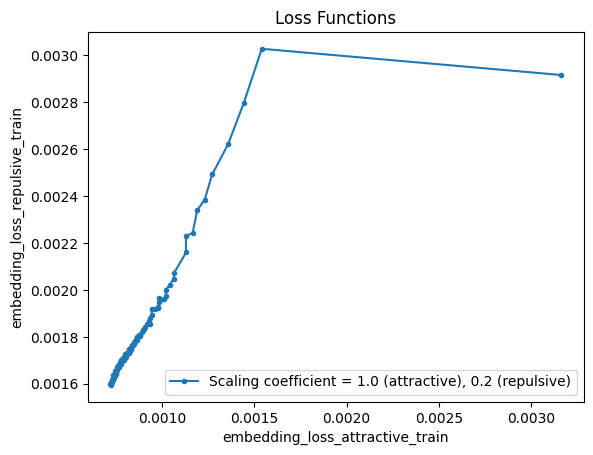

In [19]:
label = f'Scaling coefficient = {1.0} (attractive), {0.2} (repulsive)'
plt.plot(loss_history['embedding_loss_attractive_train'],loss_history['embedding_loss_repulsive_train'],
         marker='o', markersize=3, label=label)

plt.xlabel('embedding_loss_attractive_train')
plt.ylabel('embedding_loss_repulsive_train')
plt.title('Loss Functions')

plt.legend()
plt.show()

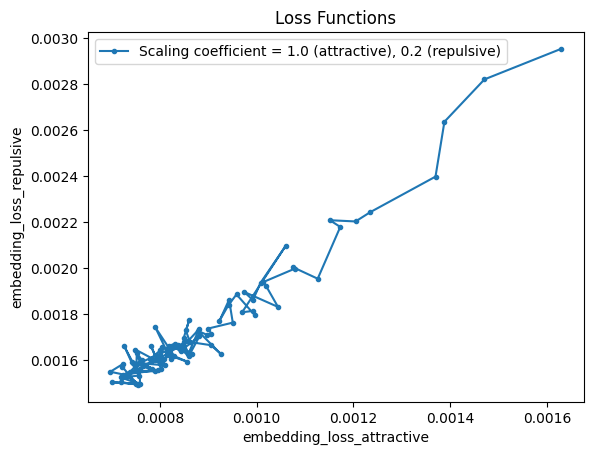

In [20]:
label = f'Scaling coefficient = {1.0} (attractive), {0.2} (repulsive)'
plt.plot(loss_history['embedding_loss_attractive'],loss_history['embedding_loss_repulsive'],
         marker='o', markersize=3, label=label)

plt.xlabel('embedding_loss_attractive')
plt.ylabel('embedding_loss_repulsive')
plt.title('Loss Functions')

plt.legend()
plt.show()